# 3. Análisis de PCA de la estación en las Palomas
## Reconocimiento de Patrones, tarea 2
## Equipo: Kathia Rangel Pompa, Juan Carlos Pérez Ramírez

### Visualizamos los datos

In [82]:
import pandas as pd

df = pd.read_csv('laspalomas.csv')
df_original = df.copy()
df.drop(['X','Id_Estacion_id','Unnamed: 0'], axis=1, inplace=True)

In [83]:
# Cambiar el formato de la fecha

df_original['Año'] = pd.to_datetime(df_original['Fecha']).dt.year
df_original['Mes'] = pd.to_datetime(df_original['Fecha']).dt.month
df_original['Dia'] = pd.to_datetime(df_original['Fecha']).dt.day
df_original['Hora'] = pd.to_datetime(df_original['Fecha']).dt.hour

df['Año'] = pd.to_datetime(df['Fecha']).dt.year
df['Mes'] = pd.to_datetime(df['Fecha']).dt.month
df['Dia'] = pd.to_datetime(df['Fecha']).dt.day
df['Hora'] = pd.to_datetime(df['Fecha']).dt.hour
df.drop(['Fecha'], axis=1, inplace=True)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88666 entries, 0 to 88665
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precipitacion  83199 non-null  float64
 1   Temp_aire      72355 non-null  float64
 2   Año            88666 non-null  int32  
 3   Mes            88666 non-null  int32  
 4   Dia            88666 non-null  int32  
 5   Hora           88666 non-null  int32  
dtypes: float64(2), int32(4)
memory usage: 2.7 MB


**Notamos que tenemos muchas observaciones con datos faltantes, por lo que primero analizamos dónde se encuentran los valores nulos:**

In [85]:
# Ver las filas con valores nulos

valores_nulos = df[df.isnull().any(axis=1)]
print(valores_nulos['Año'].value_counts())
print(len(valores_nulos))

Año
2007    4131
2006    2846
2020    1913
2019    1899
2014     962
2004     708
2009     694
2005     643
2021     430
2003     420
2023     402
2022     397
2017     261
2018     240
2008     195
2011     133
2013     121
2010      52
2012       3
2015       2
2016       2
Name: count, dtype: int64
16454


**Ya que tenemos años con demasiados valores nulos, decidimos eliminarlos y, los restantes, rellenarlos con la media por mes de los datos disponibles.**

In [86]:
# Eliminar años con muchos valores nulos
años_a_eliminar = [2006, 2007, 2020, 2019]
df = df[~df['Año'].isin(años_a_eliminar)]

# Rellenar valores nulos con la media del mes de cada año
media_mes = df.groupby(['Año','Mes'])['Temp_aire'].mean()
df['Temp_aire'] = df.apply(lambda x: media_mes[x['Año'], x['Mes']] if pd.isnull(x['Temp_aire']) else x['Temp_aire'], axis=1)
media_mes_prec = df.groupby(['Año','Mes'])['Precipitacion'].mean()
df['Precipitacion'] = df.apply(lambda x: media_mes_prec[x['Año'], x['Mes']] if pd.isnull(x['Precipitacion']) else x['Precipitacion'], axis=1)

# Verificar si quedan valores nulos
print(df.isnull().sum())

Precipitacion    1999
Temp_aire        2731
Año                 0
Mes                 0
Dia                 0
Hora                0
dtype: int64


**Notamos que aún hay entradas nulas, lo cual sucede porque hay años donde en todas las entradas de un mes no se registró la Temperatura o la Precicipitación. Para solucionarlo, decidimos completarlos con la media del mes en todos los años.**

In [87]:
media_temp_gral = df.groupby('Mes')['Temp_aire'].mean()
media_prec_gral = df.groupby('Mes')['Precipitacion'].mean()

df['Temp_aire'] = df['Temp_aire'].fillna(df['Mes'].map(media_temp_gral))
df['Precipitacion'] = df['Precipitacion'].fillna(df['Mes'].map(media_prec_gral))

print(df.isnull().sum())

Precipitacion    0
Temp_aire        0
Año              0
Mes              0
Dia              0
Hora             0
dtype: int64


## Gráficas informativas

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

1. Graficamos la temperatura promedio anual para visualizar si la temperatura ha aumentado o disminuido a lo largo de los años.

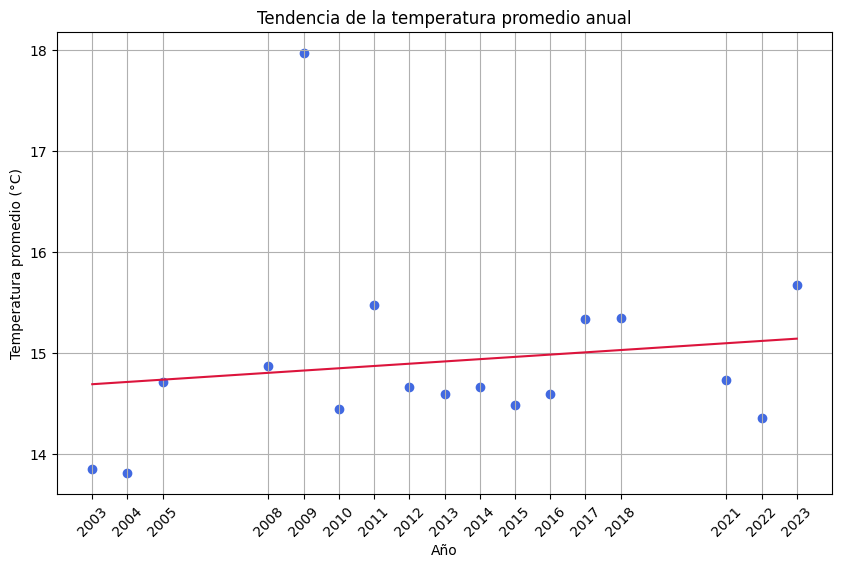

In [89]:
from sklearn.linear_model import LinearRegression

temp_promedio_anual = df.groupby('Año')['Temp_aire'].mean()

X = temp_promedio_anual.index.values.reshape(-1, 1)
y = temp_promedio_anual.values

reg = LinearRegression().fit(X, y)
pred = reg.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(temp_promedio_anual.index, temp_promedio_anual.values, color='royalblue')
plt.plot(temp_promedio_anual.index, pred, color='crimson')
plt.xticks(temp_promedio_anual.index, rotation=45)
plt.xlabel('Año')
plt.ylabel('Temperatura promedio (°C)')
plt.title('Tendencia de la temperatura promedio anual')
plt.grid(True)
plt.show()

En general, vemos que la temperatura promedio muestra una tendencia ascendente, por lo que existe un calentamiento gradual a lo largo de los años. También podemos identificar años atípicos, como el $2009$, el cual tuvo mediciones más calurosas de lo normal. Los huecos que se ven en la gráfica son debido a los años que eliminamos previamente.

2. Graficamos la temperatura promedio por mes a lo largo de todos los años para visualizar el comportamiento en las diferentes estaciones.

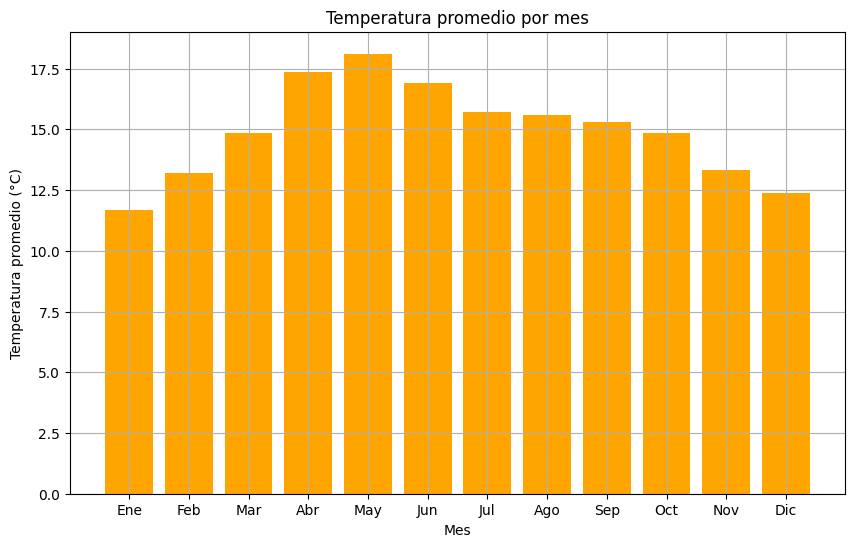

In [90]:
# Calcular la temperatura promedio por mes
temp_promedio_mensual = df.groupby('Mes')['Temp_aire'].mean()

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(temp_promedio_mensual.index, temp_promedio_mensual.values, color='orange')
plt.xlabel('Mes')
plt.ylabel('Temperatura promedio (°C)')
plt.title('Temperatura promedio por mes')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.grid(True)
plt.show()

Comprobamos que la temperatura mensual promedio de nuestros datos siguen un patrón similar al de las estaciones del año, donde los primeros meses son más fríos, después la temperatura comienza a subir para posteriormente volver a bajar en los últimos meses del año.

3. Graficamos el porcentaje de días con precipitación por mes para identificar los meses más lluviosos.

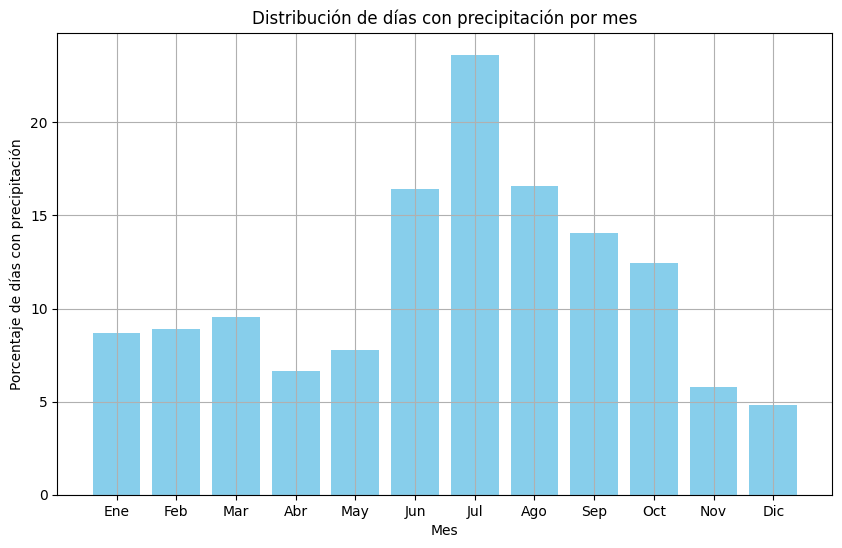

In [91]:
# Crear una columna binaria: 1 si hay precipitación, 0 si no
df['Precipitacion_binaria'] = df['Precipitacion'].apply(lambda x: 1 if x > 0 else 0)

# Calcular el porcentaje de días con precipitación por mes
precipitacion_mensual = df.groupby('Mes')['Precipitacion_binaria'].mean() * 100

plt.figure(figsize=(10, 6))
plt.bar(precipitacion_mensual.index, precipitacion_mensual.values, color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Porcentaje de días con precipitación')
plt.title('Distribución de días con precipitación por mes')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.grid(True)
plt.show()

Debido a que la precipitación es una variable mixta, decidimos transformarla a valores binarios, donde $0$ es un día con precipitación $0$ y $1$ en otro caso. En nuestra gráfica, podemos ver que la temporada de lluvias comienza en Junio y termina en Octubre.

4. Graficamos la relación entre temperatura y precipitación para identificar si hay dependencia.

               Temp_aire  Precipitacion
Temp_aire        1.00000       -0.05409
Precipitacion   -0.05409        1.00000


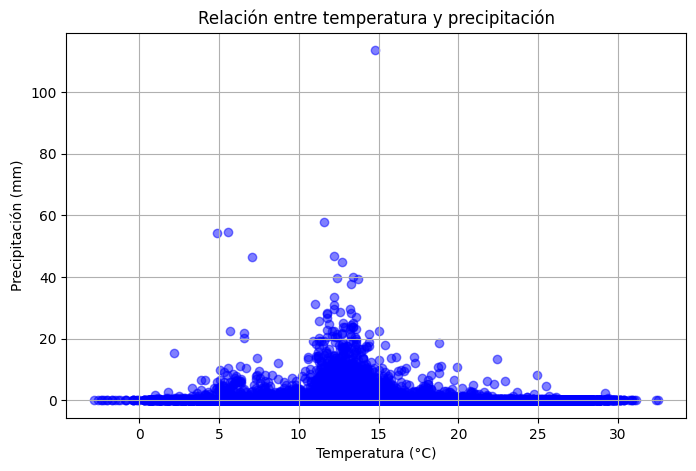

In [92]:
import matplotlib.pyplot as plt

corr_temp_prec = df[['Temp_aire', 'Precipitacion']].corr()
print(corr_temp_prec)

plt.figure(figsize=(8, 5))
plt.scatter(df['Temp_aire'], df['Precipitacion'], alpha=0.5, color="blue")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Precipitación (mm)")
plt.title("Relación entre temperatura y precipitación")
plt.grid(True)
plt.show()

Cuando analizamos el comportamiento de dos variables siempre es útil preguntarnos si existe una relación lineal entre ellas, sin embargo, en este caso no parece ser así. Una correlación de $-0.05$ nos indica una independencia entre precipitación y temperatura, esto puede deberse a que haya otros factores meteorológicos que tengan un mayor impacto en la precipitación.

## Aplicamos PCA a la Temperatura

In [93]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Creamos un DataFrame con la temperatura promedio por año y mes
añoXmes = df.pivot_table(index='Año', columns='Mes', values='Temp_aire', aggfunc='mean')

# Normalizamos los datos
df_std = StandardScaler().fit_transform(añoXmes)

# Aplicamos PCA con 5 componentes
pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_std)

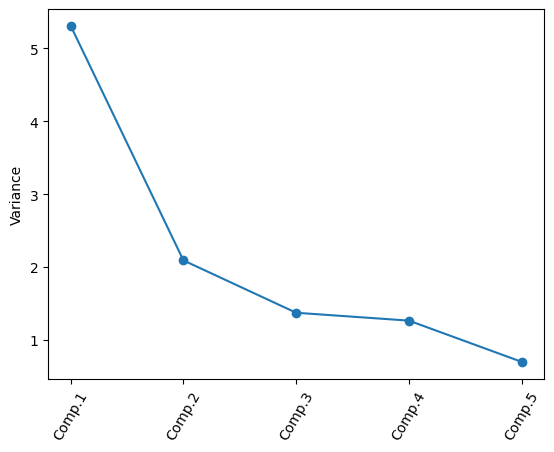

In [94]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, df_std)

In [95]:
print("Variabilidad: ",pca.explained_variance_ratio_)
print("Variabilidad Acumulada: ", pca.explained_variance_ratio_.cumsum())

Variabilidad:  [0.44218404 0.17417415 0.11434449 0.10535973 0.0582832 ]
Variabilidad Acumulada:  [0.44218404 0.61635819 0.73070268 0.83606241 0.8943456 ]


La gráfica de arriba muestra la variabilidad de los datos que representa cada componente. Con $5$ componentes, capturamos el $89.4%$ de la variabilidad de los datos.

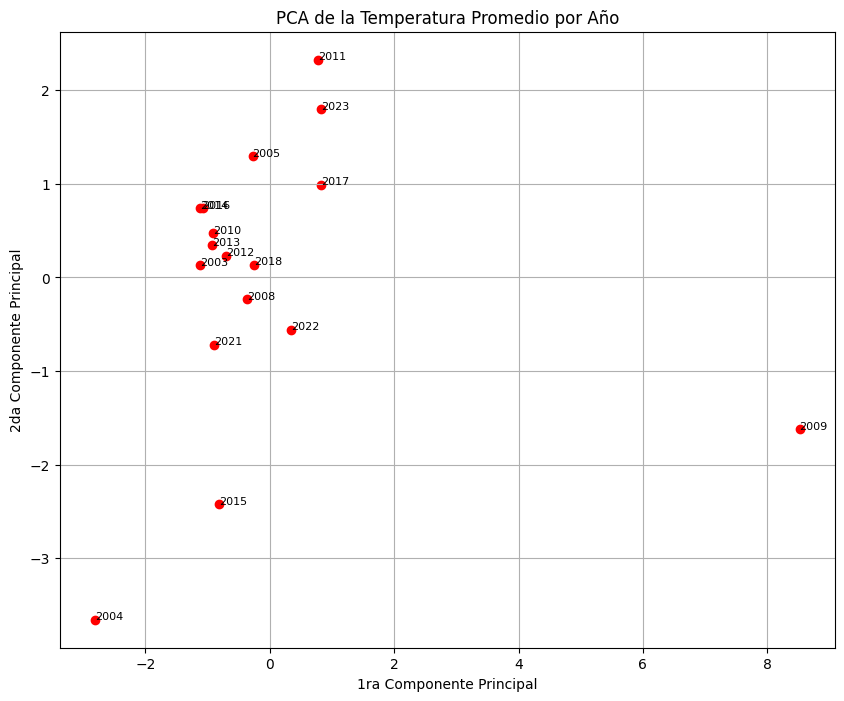

In [96]:
# Graficamos un biplot
plt.figure(figsize=(10, 8))
plt.scatter(df_pca[:, 0], df_pca[:, 1], color="red")
for i, año in enumerate(añoXmes.index):
    plt.annotate(año, (df_pca[i, 0], df_pca[i, 1]), fontsize=8)
plt.xlabel("1ra Componente Principal")
plt.ylabel("2da Componente Principal")
plt.title("PCA de la Temperatura Promedio por Año")
plt.grid(True)
plt.show()

El biplot es muy útil para identificar años con patrones de temperatura similares y también aquellos atípicos. Nuevamente, observamos que el año $2009$ tuvo un patrón en su temperatura muy diferente al resto de los años. 

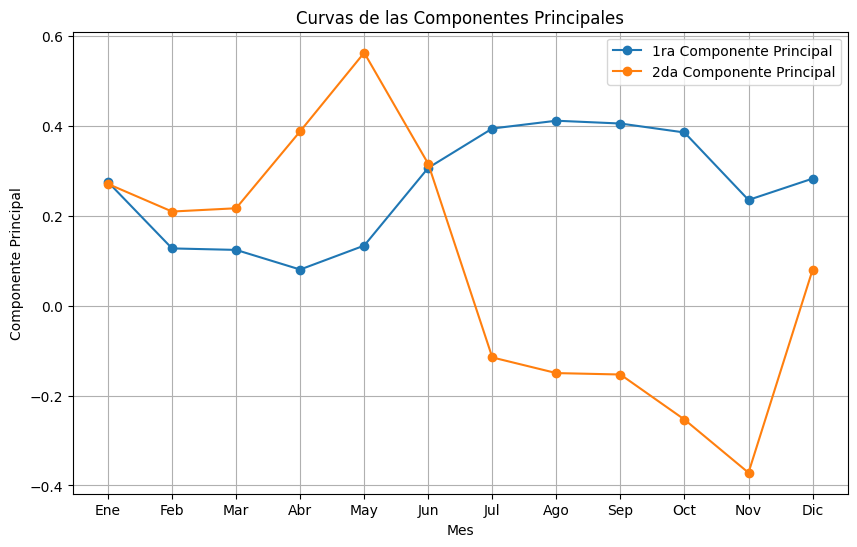

In [97]:
# Graficamos las curvas de las componentes principales

l1 = pca.components_[0]
l2 = pca.components_[1]

plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), l1, marker='o', label='1ra Componente Principal')
plt.plot(range(1, 13), l2, marker='o', label='2da Componente Principal')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.xlabel('Mes')
plt.ylabel('Componente Principal')
plt.title('Curvas de las Componentes Principales')
plt.legend()
plt.grid(True)
plt.show()

Vemos en las curvas de las componentes que la primera componente captura mayormente la variación en los últimos $6$ meses del año, mientras que la segunda componente tiene coeficientes más altos en los primeros meses del año. Los picos en los meses de Mayo y Noviembre indican que estos meses tienen una influencia alta para explicar la variabilidad de nuestros datos.

In [98]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], fontsize = 8, color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

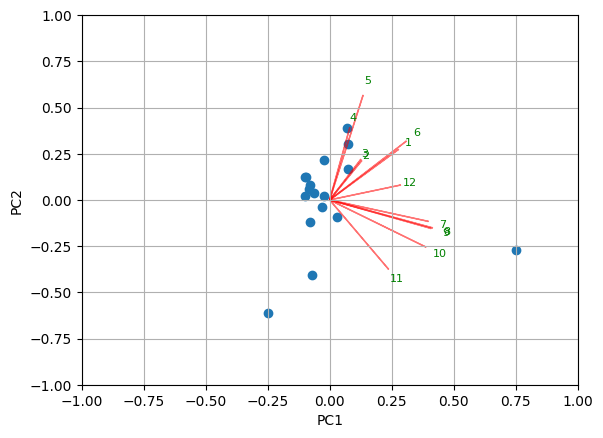

In [99]:
myplot(df_pca[:,0:2], np.transpose(pca.components_[0:2, :]), list(añoXmes.columns))

Comprobamos que las variables de los meses de Mayo ($5$) y Noviembre ($11$) tienen una gran contribución a las componentes principales.